In [1]:
import torch
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Audio

import scipy.io.wavfile
import os
import sys
from moviepy.editor import *

In [2]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

In [3]:
# get path of current file
if not 'notebookDir' in globals():
    notebookDir = os.getcwd()
print('notebookDir: ' + notebookDir)
os.chdir(notebookDir)
os.chdir("text-to-image/vqgan")

notebookDir: /home/user/Dokumente/#master/HACKATUM/git/HackaTUM2021


In [4]:
PROMPT = '''White lips, pale face
Breathing in snowflakes
Burnt lungs, sour taste
Light's gone, day's end
Struggling to pay rent
Long nights, strange men'''
n=1
PATH="../output/vqgan/gen.png"

In [5]:
cmd = '''python -u main.py test cc12m_32x1024_vitgan.th "''' + PROMPT + '''"''' + ''' --nb-repeats=''' + str(n) + ''' --out-path=''' + PATH + ''' --images-per-row=''' + str(n)

p = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True, stderr=subprocess.PIPE)
stdout, stderr = p.communicate()
print(stdout, stderr)

b'Working with z of shape (1, 256, 16, 16) = 65536 dimensions.\nloaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth\nVQLPIPSWithDiscriminator running with hinge loss.\nRestored from vqgan_imagenet_f16_16384.ckpt\n' b'/home/user/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: DeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5\n  warnings.warn(*args, **kwargs)\n'


In [6]:

language = 'en'
speaker = 'lj_16khz'
device = torch.device('cpu')
model, symbols, sample_rate, example_text, apply_tts = torch.hub.load(repo_or_dir='snakers4/silero-models',
                                                                      model='silero_tts',
                                                                      language=language,
                                                                      speaker=speaker,
                                                                      model_math='fp64')
torch.set_default_dtype(torch.float64)
model = model.to(device)  # gpu or cpu
model.eval()

Using cache found in /home/user/.cache/torch/hub/snakers4_silero-models_master


RecursiveScriptModule(
  original_name=TTSModel
  (tacotron): RecursiveScriptModule(
    original_name=Tacotron2_jit
    (embedding): RecursiveScriptModule(original_name=Embedding)
    (encoder): RecursiveScriptModule(
      original_name=Encoder
      (convolutions): RecursiveScriptModule(
        original_name=ModuleList
        (0): RecursiveScriptModule(
          original_name=Sequential
          (0): RecursiveScriptModule(
            original_name=ConvNorm
            (conv): RecursiveScriptModule(original_name=Conv1d)
          )
          (1): RecursiveScriptModule(original_name=BatchNorm1d)
        )
        (1): RecursiveScriptModule(
          original_name=Sequential
          (0): RecursiveScriptModule(
            original_name=ConvNorm
            (conv): RecursiveScriptModule(original_name=Conv1d)
          )
          (1): RecursiveScriptModule(original_name=BatchNorm1d)
        )
        (2): RecursiveScriptModule(
          original_name=Sequential
          (0): R

In [7]:
res1 = []
for i in range(round(len(PROMPT)/139)):
    
    audio = apply_tts(texts=PROMPT[i*140:(i+1)*140],
                  model=model,
                  sample_rate=sample_rate,
                  symbols=symbols,
                  device=device)
    #print(list(audio[0].numpy().flatten()))
    
    res1.extend(list(audio[0].numpy().flatten()))
    res1.extend([0]*16000)

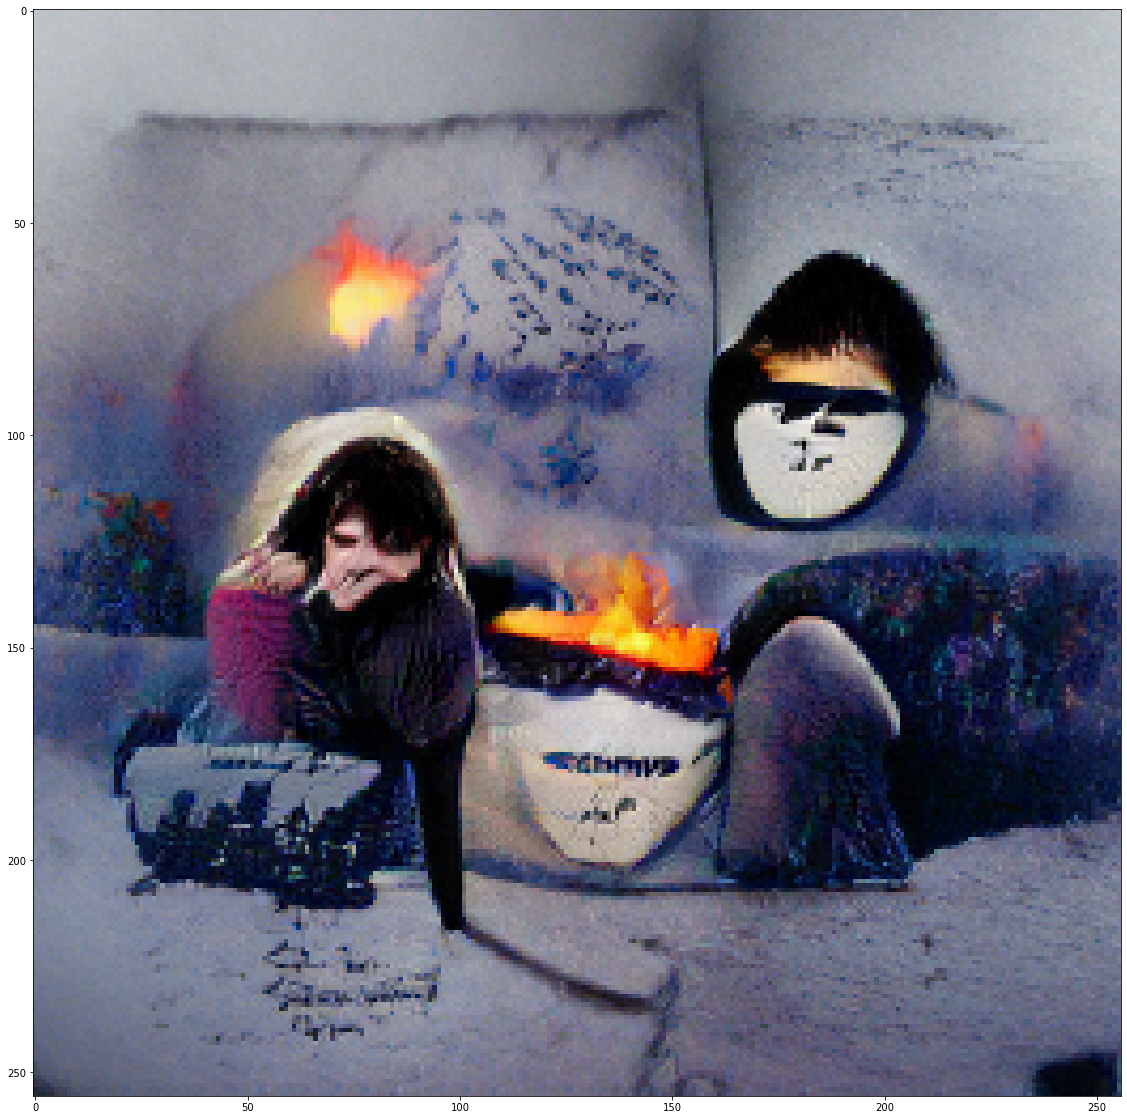

In [8]:
plt.figure(figsize = (20,20))
img = mpimg.imread('../output/vqgan/gen.png')
imgplot = plt.imshow(img)
plt.show()

Audio(res1, rate=16000)




scipy.io.wavfile.write("karplus.wav", 16000, np.asarray(res1))

In [9]:
command = f"ffmpeg -i karplus.wav -vn -ar 44100 -ac 2 -b:a 192k output.mp3"
os.system(command)

0

In [10]:
  
clips = [ImageClip(m).set_duration(2)
         for m in ['../output/vqgan/gen.png']]



concat_clip = concatenate_videoclips(clips, method="compose")



audioclip = AudioFileClip("output.mp3")

new_audioclip = CompositeAudioClip([audioclip])
concat_clip.audio = new_audioclip




concat_clip.write_videofile("test.mp4", fps=24)


t:   0%|          | 0/48 [00:00<?, ?it/s, now=None]                 

Moviepy - Building video test.mp4.
MoviePy - Writing audio in testTEMP_MPY_wvf_snd.mp3
MoviePy - Done.
Moviepy - Writing video test.mp4



Moviepy - Done !
Moviepy - video ready test.mp4


In [11]:
concat_clip.ipython_display(fps=24, loop=1, autoplay=1)

chunk:  44%|████▎     | 97/222 [00:00<00:00, 969.29it/s, now=None]

Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [12]:
command = f"rm  karplus.wav output.mp3"
os.system(command)

0